In [4]:
from dotenv import load_dotenv
load_dotenv()

True

# Setup

In [37]:
import json
import getpass
import os
import pandas as pd
from docx import Document as DocxDocument
from IPython.display import Image, display
from pydantic import Field
from pydantic import BaseModel
from typing import TypedDict, List, Annotated, Optional, Literal
from langchain import hub
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.docstore.document import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AnyMessage, AIMessage
from fuzzywuzzy import fuzz

In [6]:
from langfuse.callback import CallbackHandler

langfuse_handler = CallbackHandler(
  secret_key="sk-lf-aac7fcae-34e3-46d6-afc5-247c8ea59682",
  public_key="pk-lf-36ecf322-0d82-4071-acb2-5a77ed6858a5",
  host="https://cloud.langfuse.com"
)

In [7]:
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


In [8]:
vector_store = InMemoryVectorStore(embeddings)

# Document loader

In [32]:
df_cities = pd.read_csv("/home/jovyan/projects/marin/delta-chatbot/notebooks/cities_per_en.csv")
df_regions = pd.read_csv("/home/jovyan/projects/marin/delta-chatbot/notebooks/regions.csv")

In [10]:
docx = DocxDocument("/home/jovyan/projects/marin/delta-chatbot/notebooks/delta.docx")
text = "\n".join([para.text for para in docx.paragraphs if para.text.strip()])

docs = [Document(page_content=text, metadata={"source": "/content/drive/My Drive/delta.docx"})]

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [12]:
_ = vector_store.add_documents(documents=all_splits)

prompt = hub.pull("rlm/rag-prompt")

/opt/conda/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Functions & Classes

In [38]:
PROPERTY_TYPE_MAPPING = {
    "زمین": {"url": "store", "display": "زمین"},
    "آپارتمان موقعیت اداری": {"url": "OfficeLocationApartment", "display": "آپارتمان موقعیت اداری"},
    "باغ": {"url": "garden", "display": "باغ"},
    "باغچه": {"url": "garden", "display": "باغ"},
    "تجاری": {"url": "commercial", "display": "تجاری"},
    "مغازه": {"url": "commercial", "display": "مغازه"},
    "آپارتمان": {"url": "apartment", "display": "آپارتمان"}
}
property_types = list(PROPERTY_TYPE_MAPPING.keys())

In [39]:
def fuzzy_search_return_link(user_input, df, threshold=80):
    for idx, row in df.iterrows():
        similarity = fuzz.partial_ratio(user_input.lower(), row['name'].lower())
        if similarity >= threshold:
            return row['link']
    return None

In [88]:
def search_properties(min_meter: Optional[int] = None, max_meter: Optional[int] = None,
                      min_price: Optional[int] = None, max_price: Optional[int] = None,
                      neighborhood: Optional[str] = None,
                      city: Optional[str] = "tehran", elevator: Optional[bool] = None,
                      property_type: Optional[str] = "apartment") -> str:
    """
    if the user wants to buy or rent property make url with filters for city, area, price, elevator, and property type.
    """

    if not property_type:
        property_type = "apartment"
    else:
        property_type = PROPERTY_TYPE_MAPPING[property_type]["url"]
        
    base_url = f"https://deltadev.ir/{city}/buy/{property_type}"

    if neighborhood:
        fuzzy_result = fuzzy_search_return_link(neighborhood, df_regions)
        if fuzzy_result:
            base_url = base_url + '/' + fuzzy_result
            
    query_params = []
    if min_meter is not None and max_meter is not None:
        query_params.append(f"meter={min_meter}-{max_meter}")
    elif min_meter is not None:
        query_params.append(f"meter={min_meter}-")
    elif max_meter is not None:
        query_params.append(f"meter=-{max_meter}")

    if min_price is not None and max_price is not None:
        query_params.append(f"price={min_price}-{max_price}")
    elif min_price is not None:
        query_params.append(f"price={min_price}-")
    elif max_price is not None:
        query_params.append(f"price=-{max_price}")

    if elevator:
        query_params.append("features=elevator")

    query_string = "?" + "&".join(query_params) if query_params else ""
    url = base_url + query_string

    filters = []
    if min_meter is not None and max_meter is not None:
        filters.append(f"{min_meter} تا {max_meter} متر")
    elif min_meter is not None:
        filters.append(f"حداقل {min_meter} متر")
    elif max_meter is not None:
        filters.append(f"حداکثر {max_meter} متر")

    if min_price is not None and max_price is not None:
        filters.append(f"بین {min_price:,} تا {max_price:,} تومان")
    elif min_price is not None:
        filters.append(f"حداقل {min_price:,} تومان")
    elif max_price is not None:
        filters.append(f"حداکثر {max_price:,} تومان")

    if elevator:
        filters.append("با آسانسور")

    if filters:
        filters_str = "، ".join(filters)
        explanation = f"با ویژگی‌هایی که گفتید ({filters_str})، می‌توانید بر روی این لینک کلیک کنید و ملک‌های مشابه را پیدا کنید: {url}"
    else:
        explanation = f"می‌توانید بر روی این لینک کلیک کنید و ملک‌های موجود را مشاهده کنید: {url}"

    return url

In [89]:
class PropertyFeatures(BaseModel):
    min_meter: Optional[int] = Field(default=None, description="Minimum square meters")
    max_meter: Optional[int] = Field(default=None, description="Maximum square meters")
    min_price: Optional[int] = Field(default=None, description="Minimum price in Tomans")
    max_price: Optional[int] = Field(default=None, description="Maximum price in Tomans")
    neighborhood: Optional[str] = Field(default=None, description="Neighborhood in tehran in persian")
    city: Literal[tuple(df_cities['city'])] = Field(default="other", description="City name")
    elevator: Optional[bool] = Field(default=None, description="Elevator required (True/False)")
    property_type: Literal[*property_types]= Field(default="other", description="property type") 

In [90]:
class FollowUpQuestions(BaseModel):
    follow_up_questions: List[str]

In [91]:
from langchain_core.messages import AnyMessage 

class State(TypedDict):
    messages: List[AnyMessage]
    follow_up_questions: List[str]

# Tools

In [96]:
@tool
def retrieve(query: str):
    """Retrieves relevant documents based on the last message content."""
    print("retrieve tool used: ", property_features)
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool
def make_buy_url(query: str):
    """
    If user wants to buy a property, 
    Extracts property features from the last message using a structured LLM 
    and make a url based on features.
    """
    structured_llm = llm.with_structured_output(PropertyFeatures)
    property_features = structured_llm.invoke(query)
    print("make_buy_url tool used with this parameters: ", property_features)

    result = search_properties(**property_features.model_dump())

    return result
    
tools = [retrieve, make_buy_url]

# Chains

In [97]:
def query_or_respond(state: State):
    """Generate tool call or respond."""
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


def generate(state: State):
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(
        doc.content for doc in tool_messages
        if not doc.content.startswith("Source:")
    )
    system_message_content = (
        "You are an Real estate consultant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer Persian. "
        "If you got an url, give the url to user and don't change the url. "
        "If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the answer concise. "
        "don't mention the source of the document, only answer it"
        "Provide only the answer, no source or metadata."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(content=system_message_content)] + conversation_messages

    response = llm.invoke(prompt)

    follow_up_system_message = SystemMessage(
        content=(
            "Based on the user's query, suggest 2-3 relevant follow-up questions in Persian. "
            "Return each question on a new line."
        )
    )
    follow_up_prompt = [follow_up_system_message] + prompt + [response]
    follow_up_response = llm.invoke(follow_up_prompt)

    follow_up_questions = [
        q.strip() for q in follow_up_response.content.split("\n") if q.strip()
    ]

    return {
        "messages": [AIMessage(content=response.content)],
        "follow_up_questions": follow_up_questions
    }


graph_builder = StateGraph(State)
graph_builder.add_node(query_or_respond)
tool_node = ToolNode(tools)
graph_builder.add_node(tool_node)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

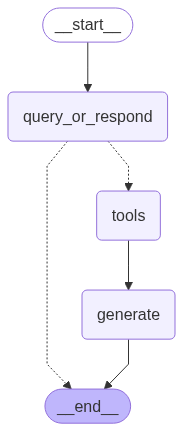

In [71]:
graph

# Usage

In [72]:
import uuid
thread_id = str(uuid.uuid4())
config={
    "callbacks": [langfuse_handler],
    "configurable": {"thread_id": thread_id},
    "metadata": {"langfuse_session_id": thread_id},
}

In [99]:
# input_message = "میخوام یه خونه تو قیطریه بخرم بالای 3 میلیارد و زیر 200 متر"
input_message = "میخوام یه خونه تو ولیعصر بخرم بالای 3 میلیارد و زیر 200 متر"

result = graph.invoke(
    {"messages": [{"role": "user", "content": input_message}]},
    config=config
)

result["messages"][-1].pretty_print()

if "follow_up_questions" in result:
    print("\nسوالات پیشنهادی:")
    for q in result["follow_up_questions"]:
        print("-", q)


make_buy_url tool used with this parameters:  min_meter=1 max_meter=200 min_price=3000000000 max_price=None neighborhood='ولیعصر' city='tehran' elevator=None property_type='آپارتمان'
================================== Ai Message ==================================

برای خرید آپارتمان در منطقه ۳ تهران در محدوده میدان ولیعصر و خیابان Parkway با متراژ بین ۱ تا ۲۰۰ متر و قیمت حداکثر ۳ میلیارد تومان می‌توانید به لینک زیر مراجعه کنید: https://deltadev.ir/tehran/buy/apartment/region-3-valiasr-parkway?meter=1-200&price=3000000000-

سوالات پیشنهادی:
- آیا به دنبال اطلاعات بیشتری درباره امکانات موجود در آپارتمان‌ها هستید؟
- شما چه نوع خریدی در نظر دارید، خرید و یا اجاره؟
- بودجه شما برای خرید آپارتمان چقدر است؟


In [33]:
df_regions


,name,link
0,دربند,region-1-darband
1,نیاوران,region-1-niavaran
2,جمشیدیه جماران,region-1-jamshidiyeh-jamaran
3,زعفرانیه,region-1-zafaraniyeh
4,محمودیه,region-1-mahmoodiyeh
...,...,...
461,شهرک شهید خرازی,region-21-22-kharazi-town
462,پژوهش شمالی,region-21-22-north-pajoohesh
463,کوهک,region-21-22-kuhak
464,آزادشهر,region-21-22-azadshahr
